In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson

np.random.seed(42)

## Linear Regression

$$ Y = X\theta + \epsilon $$
as we take error $\epsilon$ to be guassian

$$ Y \sim N(\mu, \Sigma) \text{ where } \mu = X\theta$$


In [2]:
# create toy data where X has 2 features and sample size is 1000
x = np.random.random(1000) * 10
# x

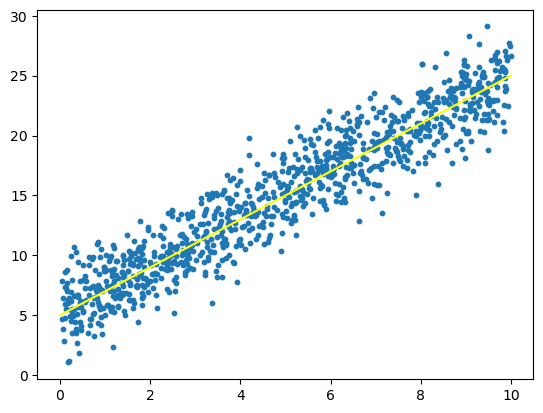

In [3]:
a = 2
b = 5
error_std = 2

# add guassian noise
y = a * x + b + np.random.normal(loc=0, scale=error_std, size=1000)
plt.scatter(x, y, s=10)
x_axis = np.linspace(0, 10, 100)
plt.plot(x_axis, a*x_axis + b, color='yellow')

using normal equation to find the parameters
$$ \theta = (X^TX)^{-1} X^Ty $$

In [4]:
X = np.column_stack([x, np.ones(x.shape[0])])
X

array([[3.74540119, 1.        ],
       [9.50714306, 1.        ],
       [7.31993942, 1.        ],
       ...,
       [1.36818631, 1.        ],
       [9.50237354, 1.        ],
       [4.46005773, 1.        ]])

In [5]:
theta = np.linalg.multi_dot([np.linalg.inv(X.T.dot(X)), X.T, y])
theta

array([1.96904297, 5.34956052])

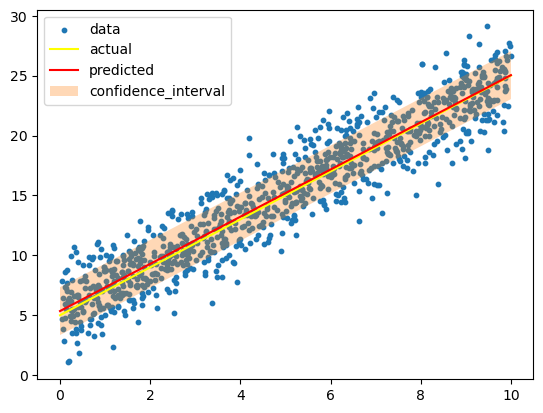

In [6]:
sigma = 1

plt.scatter(x, y, s=10, label='data')
x_axis = np.linspace(0, 10, 100)
y_pred = theta[0]*x_axis + theta[1]
plt.plot(x_axis, a*x_axis + b, color='yellow', label='actual')
plt.plot(x_axis, y_pred, color='red', label='predicted')

# showing 95 % confidence interval using 2sigma
plt.fill_between(x_axis, y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.3, label='confidence_interval')

plt.legend()

Q1
(A) the expected value of p(y|x) is the predicted line or it tells what is most likely to be the y for that given x

(B) sigma has no role, it is only deciding the bounding confidence interval

(C) taking poisson dist

## Regression by Poisson y

poisson distribution belongs to the exponential family

so if we use poisson distribution to make our linear model\
we are considering that the error is poisson distributed or 
$$ y|x ;\theta \sim Poisson(\lambda) $$


by applying the concepts of GLM, we find that

$$ \lambda = e^{\theta^T x} $$
$$ E(y|x;\theta) = \lambda  $$
$$ \implies h_\theta(x) = e^{\theta^T x} $$

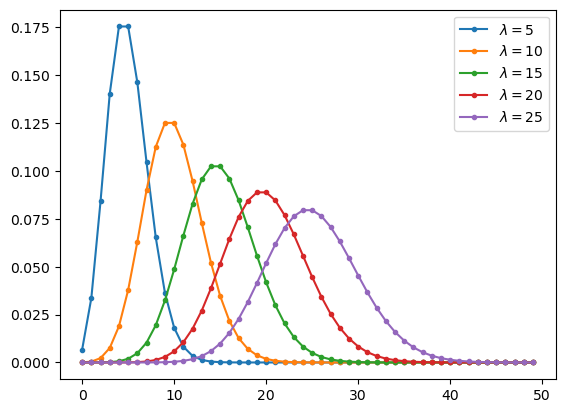

In [7]:
# visualising poisson distribution

poisson_x_axis = np.arange(0, 50)

for i in range(5, 30, 5):
    plt.plot(poisson_x_axis, poisson.pmf(poisson_x_axis, mu=i), marker='.', label=f'$\lambda=${i}')

plt.legend()

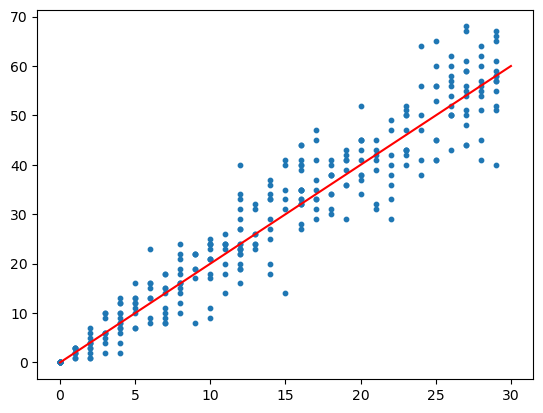

In [8]:
# creating toy data

a = 2
lam = 3  # lambda of poisson
b = 0
n = 300

x = np.random.randint(0, 30, size=(n))

# I think it has to be done this way. (I'm not very sure)
# by following the assumption of GLM, y given some x follows the poisson dist

# hence we should do something like this
y = np.random.poisson(lam=a*x + b, size=(n))

plt.scatter(x, y, s=10)

x_plot = np.arange(0, 31)
plt.plot(x_plot, a*x_plot + b , c='r')

as mentioned on [wikipedia](https://en.wikipedia.org/wiki/Poisson_regression#:~:text=Poisson%20regression%20assumes%20the%20response,used%20to%20model%20contingency%20tables.)
solving exact theta isn't possible as equation has no closed form solution \
hence we need to perform convex optimisation

the negative log likelihood (NLL) 
$J(\theta)=-\sum_{i=1}^{m}(-e^{\theta^Tx^i}+\theta^Tx^iy^i + f(y))$

common update rule for GLMs
$$\theta:=\theta-\alpha \sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}$$
so
$$\theta:=\theta-\alpha \sum_{i=1}^{m}(e^{\theta^T x^{(i)}}-y^{(i)})x^{(i)}$$

in matrix form
$$\theta:=\theta-\alpha (X^Texp(X\theta)-X^T y)$$

In [9]:
X = np.column_stack([x, np.ones(x.shape)])
theta_initial = np.zeros(2)
theta_initial

array([0., 0.])

In [10]:
def batch_GD(X, y, theta_initial, learning_rate, epochs):
    theta = theta_initial.copy()

    history_theta = np.zeros((epochs+1, theta.shape[0]))
    for epoch in range(epochs):
        history_theta[epoch] = theta

        grad = X.T.dot(np.exp(X.dot(theta))) - X.T.dot(y)
        theta -= learning_rate * grad

    history_theta[epochs] = theta

    return theta, history_theta


In [11]:
theta, history_theta = batch_GD(X, y, theta_initial, learning_rate=1e-7, epochs=100000)

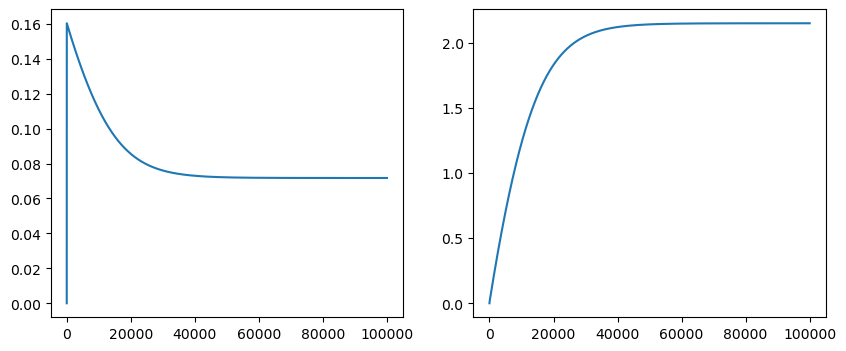

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    axes[i].plot(history_theta[:, i])

In [13]:
y_pred = np.exp(X.dot(theta))

def rmse(y, X, theta):
    y_pred = np.exp(X.dot(theta))
    return np.sqrt(np.square(y - y_pred).sum() / y.shape[0])

rmse(y, X, theta)

7.510411637285407

Text(0, 0.5, 'RMSE')

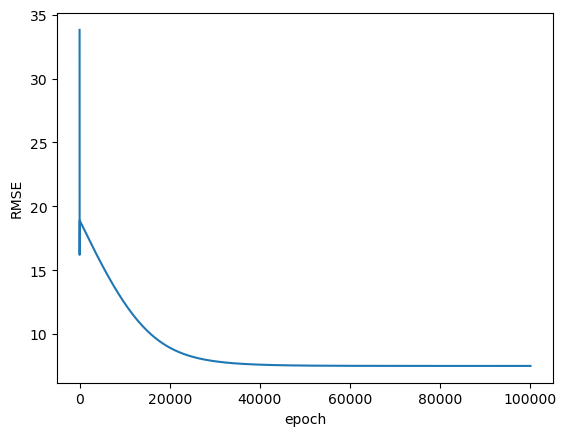

In [14]:
plt.plot([rmse(y, X, theta_epoch) for theta_epoch in history_theta])
plt.xlabel('epoch')
plt.ylabel('RMSE')

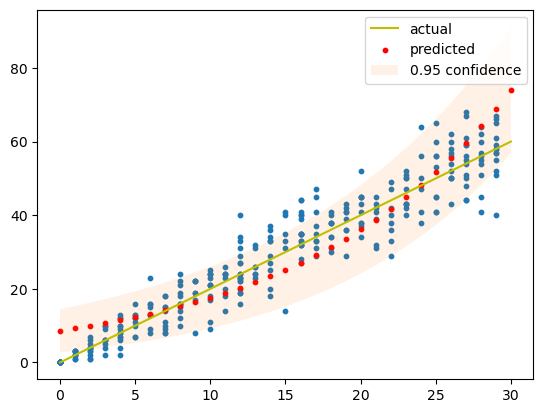

In [15]:
plt.scatter(x, y, s=10)

x_plot = np.arange(0, 31)
plt.plot(x_plot, a*x_plot + b , c='y', label='actual')

y_pred_plot = np.exp(np.column_stack([x_plot, np.ones(x_plot.shape)]).dot(theta))

plt.scatter(x_plot, y_pred_plot, c='r', s=10, label='predicted')
plt.fill_between(x_plot, y_pred_plot - 2*np.sqrt(y_pred_plot), y_pred_plot + 2*np.sqrt(y_pred_plot), alpha=0.1, label='0.95 confidence')
plt.legend()

In [16]:
from sklearn.linear_model import PoissonRegressor

regr = PoissonRegressor().fit(x.reshape(-1,1), y)

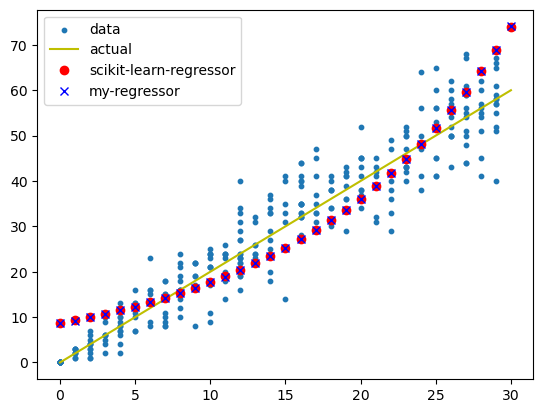

In [17]:
y_pred_plot_regr = regr.predict(x_plot.reshape(-1,1))

plt.scatter(x, y, s=10, label='data')
plt.plot(x_plot, a*x_plot + b , c='y', label='actual')

plt.plot(x_plot, y_pred_plot_regr, 'ro', label='scikit-learn-regressor')
plt.plot(x_plot, y_pred_plot, 'bx', label='my-regressor')

plt.legend()